In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import mlflow
import mlflow.keras

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


### Dataset Split

In [14]:

DATA_DIR = ".\images"      
BATCH_SIZE = 32
IMG_SIZE = (224, 224)            
EPOCHS = 25
LR = 1e-4
MODEL_NAME = "ResNet50"
OUTPUT_MODEL_PATH = f"models/22F3099_FracAtlas_ResNet50.h5"


mlflow.set_experiment("FracAtlas_Fracture_Classification")


classes = ["Fractured", "Non_Fractured"]
all_images = []
all_labels = []

for label_idx, cls in enumerate(classes):
    cls_dir = os.path.join(DATA_DIR, cls)
    for img_file in os.listdir(cls_dir):
        all_images.append(os.path.join(cls_dir, img_file))
        all_labels.append(label_idx)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42
)  

<>:1: SyntaxWarning: invalid escape sequence '\i'
<>:1: SyntaxWarning: invalid escape sequence '\i'
C:\Users\areeb\AppData\Local\Temp\ipykernel_27336\2117532057.py:1: SyntaxWarning: invalid escape sequence '\i'
  DATA_DIR = ".\images"


### Data Augumentation

In [15]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=7,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    shear_range=0.1,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

def generator(datagen, X, y):
    while True:
        for i in range(0, len(X), BATCH_SIZE):
            batch_paths = X[i:i+BATCH_SIZE]
            batch_labels = y[i:i+BATCH_SIZE]
            batch_imgs = [tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE) for p in batch_paths]
            batch_imgs = np.array([tf.keras.preprocessing.image.img_to_array(im) for im in batch_imgs])
            
            batch_iterator = datagen.flow(batch_imgs, batch_labels, batch_size=len(batch_imgs), shuffle=False)
            batch_x, batch_y = next(iter(batch_iterator))
            yield batch_x, batch_y

train_gen = generator(train_datagen, X_train, y_train)
val_gen = generator(val_datagen, X_val, y_val)

### Model Building

In [16]:


steps_train = len(X_train) // BATCH_SIZE
steps_val = len(X_val) // BATCH_SIZE


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='binary_crossentropy', metrics=['accuracy'])


best_checkpoint = ModelCheckpoint(
    OUTPUT_MODEL_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Crash-safe checkpoint 
last_checkpoint = ModelCheckpoint(
    "models/22F3099_FracAtlas_ResNet50_epoch{epoch:02d}.h5",
    save_best_only=False,
    verbose=1
)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)



### Model Training

In [17]:
with mlflow.start_run():

    mlflow.log_params({
        "model": MODEL_NAME,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LR
    })

    history = model.fit(
        train_gen,
        steps_per_epoch=steps_train,
        validation_data=val_gen,
        validation_steps=steps_val,
        epochs=EPOCHS,
        callbacks=[best_checkpoint, last_checkpoint, early_stop]
    )

    # Log metrics
    mlflow.log_metrics({
        "val_accuracy": history.history['val_accuracy'][-1],
        "val_loss": history.history['val_loss'][-1]
    })

    # Log model
    mlflow.keras.log_model(model, "model")

Epoch 1/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7785 - loss: 0.4473
Epoch 1: val_accuracy improved from None to 0.82031, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 1: saving model to models/22F3099_FracAtlas_ResNet50_epoch01.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 668s 7s/step - accuracy: 0.8438 - loss: 0.3697 - val_accuracy: 0.8203 - val_loss: 0.6743
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8870 - loss: 0.2894
Epoch 2: val_accuracy improved from 0.82031 to 0.82292, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 2: saving model to models/22F3099_FracAtlas_ResNet50_epoch02.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 609s 7s/step - accuracy: 0.8949 - loss: 0.2723 - val_accuracy: 0.8229 - val_loss: 0.5922
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9169 - loss: 0.2190
Epoch 3: val_accuracy improved from 0.82292 to 0.82447, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 3: saving model to models/22F3099_FracAtlas_ResNet50_epoch03.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 537s 6s/step - accuracy: 0.9168 - loss: 0.2149 - val_accuracy: 0.8245 - val_loss: 0.5293
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9260 - loss: 0.1916
Epoch 4: val_accuracy improved from 0.82447 to 0.82713, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 4: saving model to models/22F3099_FracAtlas_ResNet50_epoch04.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 532s 6s/step - accuracy: 0.9292 - loss: 0.1853 - val_accuracy: 0.8271 - val_loss: 0.4538
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9259 - loss: 0.1857 
Epoch 5: val_accuracy did not improve from 0.82713

Epoch 5: saving model to models/22F3099_FracAtlas_ResNet50_epoch05.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1935s 22s/step - accuracy: 0.9303 - loss: 0.1755 - val_accuracy: 0.8245 - val_loss: 0.4711
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9384 - loss: 0.1844
Epoch 6: val_accuracy did not improve from 0.82713

Epoch 6: saving model to models/22F3099_FracAtlas_ResNet50_epoch06.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 649s 7s/step - accuracy: 0.9448 - loss: 0.1641 - val_accuracy: 0.8112 - val_loss: 0.4766
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9424 - loss: 0.1635
Epoch 7: val_accuracy did not improve from 0.82713

Epoch 7: saving model to models/22F3099_FracAtlas_ResNet50_epoch07.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 662s 7s/step - accuracy: 0.9452 - loss: 0.1509 - val_accuracy: 0.8271 - val_loss: 0.6016
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9523 - loss: 0.1219
Epoch 8: val_accuracy did not improve from 0.82713

Epoch 8: saving model to models/22F3099_FracAtlas_ResNet50_epoch08.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 624s 7s/step - accuracy: 0.9490 - loss: 0.1324 - val_accuracy: 0.8203 - val_loss: 0.7301
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9559 - loss: 0.1165
Epoch 9: val_accuracy improved from 0.82713 to 0.83854, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 9: saving model to models/22F3099_FracAtlas_ResNet50_epoch09.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 551s 6s/step - accuracy: 0.9512 - loss: 0.1267 - val_accuracy: 0.8385 - val_loss: 0.5953
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9654 - loss: 0.0999
Epoch 10: val_accuracy improved from 0.83854 to 0.86436, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 10: saving model to models/22F3099_FracAtlas_ResNet50_epoch10.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 568s 6s/step - accuracy: 0.9646 - loss: 0.1094 - val_accuracy: 0.8644 - val_loss: 0.3274
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9684 - loss: 0.0872
Epoch 11: val_accuracy improved from 0.86436 to 0.88564, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 11: saving model to models/22F3099_FracAtlas_ResNet50_epoch11.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 593s 7s/step - accuracy: 0.9706 - loss: 0.0849 - val_accuracy: 0.8856 - val_loss: 0.5351
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9732 - loss: 0.0851
Epoch 12: val_accuracy did not improve from 0.88564

Epoch 12: saving model to models/22F3099_FracAtlas_ResNet50_epoch12.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 589s 7s/step - accuracy: 0.9678 - loss: 0.0861 - val_accuracy: 0.8750 - val_loss: 0.6987
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9580 - loss: 0.1148
Epoch 13: val_accuracy did not improve from 0.88564

Epoch 13: saving model to models/22F3099_FracAtlas_ResNet50_epoch13.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 613s 7s/step - accuracy: 0.9636 - loss: 0.0985 - val_accuracy: 0.8697 - val_loss: 0.5284
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9745 - loss: 0.0685
Epoch 14: val_accuracy improved from 0.88564 to 0.89628, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 14: saving model to models/22F3099_FracAtlas_ResNet50_epoch14.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 645s 7s/step - accuracy: 0.9766 - loss: 0.0624 - val_accuracy: 0.8963 - val_loss: 0.6931
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9696 - loss: 0.0797
Epoch 15: val_accuracy improved from 0.89628 to 0.90104, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 15: saving model to models/22F3099_FracAtlas_ResNet50_epoch15.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 609s 7s/step - accuracy: 0.9692 - loss: 0.0824 - val_accuracy: 0.9010 - val_loss: 0.5455
Epoch 16/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9756 - loss: 0.0693
Epoch 16: val_accuracy improved from 0.90104 to 0.90957, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 16: saving model to models/22F3099_FracAtlas_ResNet50_epoch16.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 561s 6s/step - accuracy: 0.9742 - loss: 0.0706 - val_accuracy: 0.9096 - val_loss: 0.5544
Epoch 17/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9794 - loss: 0.0700
Epoch 17: val_accuracy did not improve from 0.90957

Epoch 17: saving model to models/22F3099_FracAtlas_ResNet50_epoch17.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 545s 6s/step - accuracy: 0.9759 - loss: 0.0678 - val_accuracy: 0.9069 - val_loss: 0.6851
Epoch 18/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9760 - loss: 0.0589
Epoch 18: val_accuracy did not improve from 0.90957

Epoch 18: saving model to models/22F3099_FracAtlas_ResNet50_epoch18.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 616s 7s/step - accuracy: 0.9752 - loss: 0.0656 - val_accuracy: 0.8910 - val_loss: 0.4889
Epoch 19/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9769 - loss: 0.0693
Epoch 19: val_accuracy improved from 0.90957 to 0.91223, saving model to models/22F3099_FracAtlas_ResNet50.h5



Epoch 19: saving model to models/22F3099_FracAtlas_ResNet50_epoch19.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 650s 7s/step - accuracy: 0.9720 - loss: 0.0735 - val_accuracy: 0.9122 - val_loss: 0.5207
Epoch 20/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9638 - loss: 0.1074
Epoch 20: val_accuracy did not improve from 0.91223

Epoch 20: saving model to models/22F3099_FracAtlas_ResNet50_epoch20.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 655s 7s/step - accuracy: 0.9636 - loss: 0.0991 - val_accuracy: 0.8963 - val_loss: 0.3537
Epoch 21/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9776 - loss: 0.0529
Epoch 21: val_accuracy did not improve from 0.91223

Epoch 21: saving model to models/22F3099_FracAtlas_ResNet50_epoch21.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 606s 7s/step - accuracy: 0.9770 - loss: 0.0654 - val_accuracy: 0.7952 - val_loss: 0.7926
Epoch 22/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9795 - loss: 0.0582
Epoch 22: val_accuracy did not improve from 0.91223

Epoch 22: saving model to models/22F3099_FracAtlas_ResNet50_epoch22.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 589s 7s/step - accuracy: 0.9784 - loss: 0.0621 - val_accuracy: 0.8932 - val_loss: 0.4652
Epoch 23/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9804 - loss: 0.0550
Epoch 23: val_accuracy did not improve from 0.91223

Epoch 23: saving model to models/22F3099_FracAtlas_ResNet50_epoch23.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 832s 9s/step - accuracy: 0.9802 - loss: 0.0575 - val_accuracy: 0.8910 - val_loss: 0.5866
Epoch 24/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9856 - loss: 0.0373 
Epoch 24: val_accuracy did not improve from 0.91223

Epoch 24: saving model to models/22F3099_FracAtlas_ResNet50_epoch24.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 1754s 20s/step - accuracy: 0.9876 - loss: 0.0366 - val_accuracy: 0.8564 - val_loss: 0.5061


2025/12/06 22:29:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/06 22:29:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


In [21]:
import tensorflow as tf

best_model = tf.keras.models.load_model(OUTPUT_MODEL_PATH)
best_model.save("FracAtlas_ResNet50.h5")


### Evaluation

26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.43      0.57       143
           1       0.89      0.98      0.93       674

    accuracy                           0.89       817
   macro avg       0.86      0.71      0.75       817
weighted avg       0.88      0.89      0.87       817

Confusion Matrix:
 [[ 62  81]
 [ 12 662]]


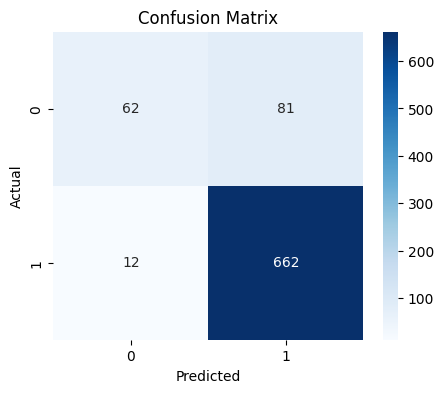

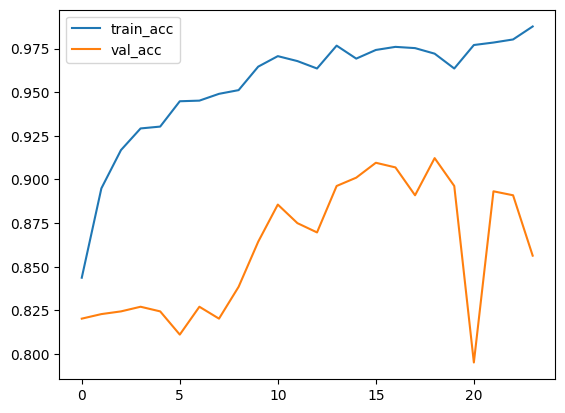

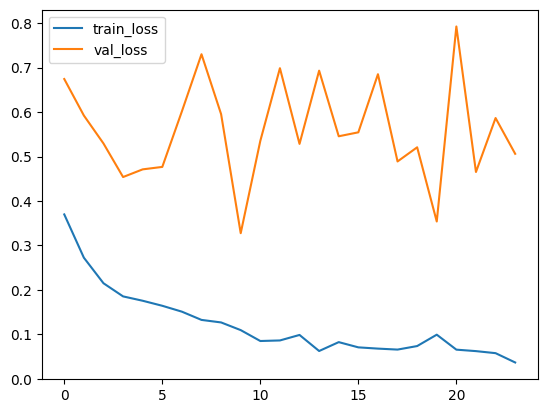

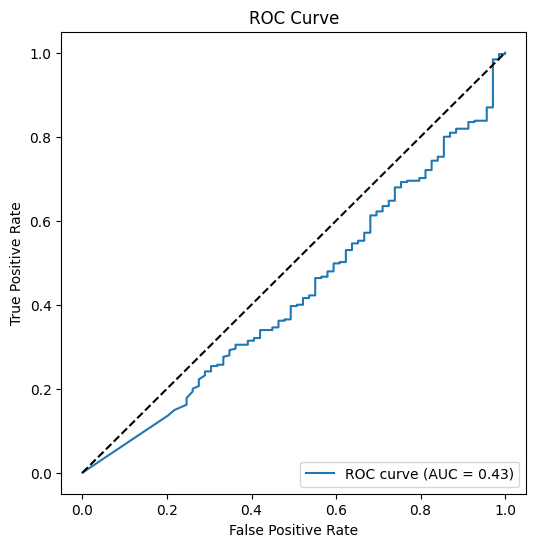

In [26]:
model.load_weights(OUTPUT_MODEL_PATH)

import seaborn as sns

def evaluate(X, y, datagen):
    batch_gen = generator(datagen, X, y)
    steps = len(X) // BATCH_SIZE + 1
    preds = model.predict(batch_gen, steps=steps)
    preds_labels = (preds > 0.5).astype(int)

    print("Classification Report:\n", classification_report(y, preds_labels))

    
    plt.figure(figsize=(5,4))
    cm = confusion_matrix(y, preds_labels)
    print("Confusion Matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("confusion_matrix.png")
    plt.show()
    

    # Plot accuracy/loss
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend()
    plt.savefig("accuracy_plot.png")

    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig("loss_plot.png")

    # ROC Curve
    f_pos_r, t_p_r, thresholds = roc_curve(y_val[:steps_val*BATCH_SIZE], preds[:steps_val*BATCH_SIZE])
    roc_auc = auc(f_pos_r, t_p_r)

    plt.figure(figsize=(6,6))
    plt.plot(f_pos_r, t_p_r, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

evaluate(X_test, y_test, val_datagen)
